# **Занятие 4. Магия нейронных сетей**

https://vk.com/lambda_brain

Мы переходим к созданию полноценной нейронной сети, с помощью которой проанализируем весьма запутанный датасет с тремя классами.


---




## **Визуализация сложных моделей**

Воспользуемся примером

https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/04-spiral_classification.ipynb

где генерируется подходящий набор данных из трёх классов, и применим к нему наш универсальный шаблон.

Сперва импортируем нужные пакеты.


In [92]:
import random
import torch
from torch import nn, optim
import numpy as np
import math
from IPython import display

В оригинальном примере используется маленькая, но очень-очень классная библиотека plot_lib, упрощающая рисование графиков на основе модели. В конце занятия вы наглядно увидите её мощь. Чтобы не возиться с её установкой, сразу включим в наш проект.

In [93]:
# https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/plot_lib.py

from matplotlib import pyplot as plt
import numpy as np
import torch


def set_default(figsize=(10, 10)):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)

Выполним начальную инициализацию графики (set_default() из plot_lib).

In [94]:
set_default()

Изучите в ноутбуке вводную теорию по многослойной нейронной сети (пункт 4):

https://github.com/DLSchool/dlschool/tree/master/06.%20PyTorch


---




## **Однослойная нейронная сеть**

Далее мы сперва создадим нейронную сеть только из двух слоёв -- входного и выходного. Это конечно на самом деле никакая не нейронная сеть, а по сути просто линейная модель, так как в ней пока не используются нейроны промежуточного слоя, где и происходит вся магия (способы эффективного обучения скрытых слоёв были придуманы относительно недавно). Хотя формально она называется **однослойная нейронная сеть**, потому что входной слой слоем не считается, а вот выходной считается.

Затем мы добавим линейной модели скрытый слой из ста нейронов и сравним эффективности.


---

Зададим сперва так называемые **гипер-параметры** -- параметры, которые не меняются в процессе обучения нейросети.

In [95]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # количество точек на признак
D = 2  # размерность данных (плоскость)
C = 3  # количество признаков
H = 100  # количество нейронов в скрытом слое

# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

В предыдущем примере и линейная модель, и модель с одним нейроном, показывали неплохие результаты. Проверим их на более сложных данных.

Воспользуемся оригинальной схемой генерации датасета.


In [96]:
# пустые тензоры, хитро заполняющиеся данными
X = torch.zeros(N * C, D).to(device) # признаки
y = torch.zeros(N * C, dtype=torch.long).to(device) # прогноз: 0, 1 или 2

for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    inner_var = torch.linspace(
        (2 * math.pi / C) * (c),
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("X:", X.shape)
print("y:", y.shape)

X: torch.Size([3000, 2])
y: torch.Size([3000])


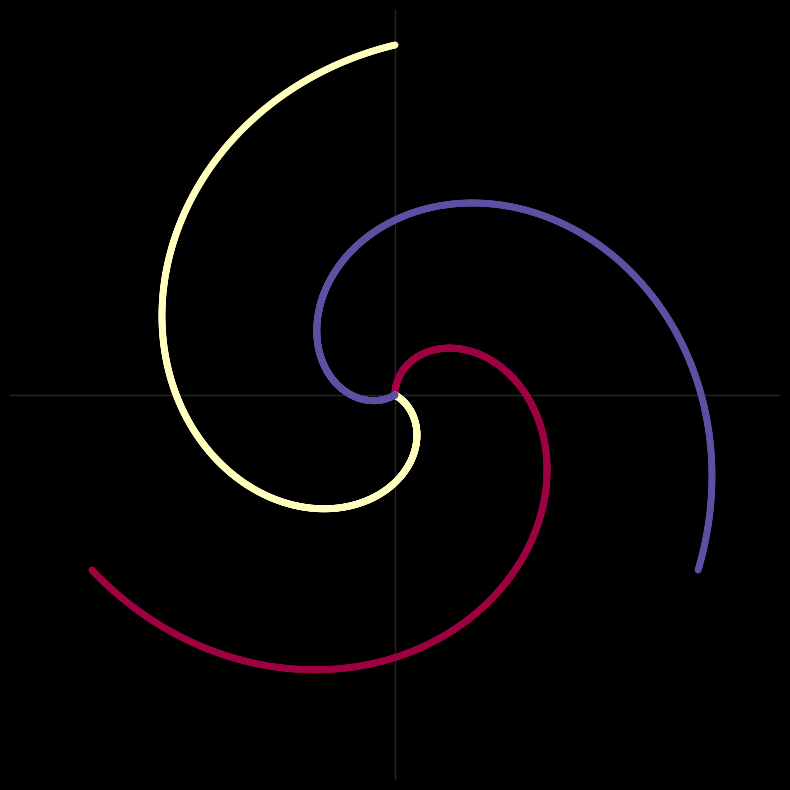

In [97]:
# визуализируем данные
plot_data(X, y)

На картинке видны три класса значений -- три закручивающиеся кривые разных цветов. Теперь воспользуемся уже проверенной схемой для создания модели, выдающей прогнозы по такому набору данных.


---


Наша линейная модель запишется так:


```
model = torch.nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C))
```




Мы подготовили промежуточную связь из 100 "коннекторов", которые пока просто соединяются друг с другом (100 выходов первой линейной модели соединяются с 100 входами второй линейной модели), как и положено однослойной нейронной сети.

Такие сети, где информация обрабатывается последовательно, от входов к выходам, называются **сети прямого распространения (feedforward neural networks, FNN / FF)** .

На следующем шаге мы добавим скрытый слой, а пока в качестве функции потерь укажем CrossEntropyLoss(). Это так называемая кросс- (перекрёстная) энтропия, которая отличается от квадратичной функции ошибок тем, что учитывает наличие у ошибки гауссового распределения.

Как обычно, корректировка нашего шаблона минимальна: указываем только модель и функцию потерь.


In [98]:
# импортируем нужные библиотеки
import torch
import numpy as np # всегда пригодится :)
from torch.nn import Linear, Sigmoid

# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# добавляем типовую функцию "шаг обучения"
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [99]:
from torch import optim, nn

model = torch.nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C))
model.to(device)

lambda_l2 = 0.00001
lr = 0.1
n_epochs = 1000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lambda_l2)
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
   loss = train_step(X, y)

print(loss)

0.7562822103500366


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


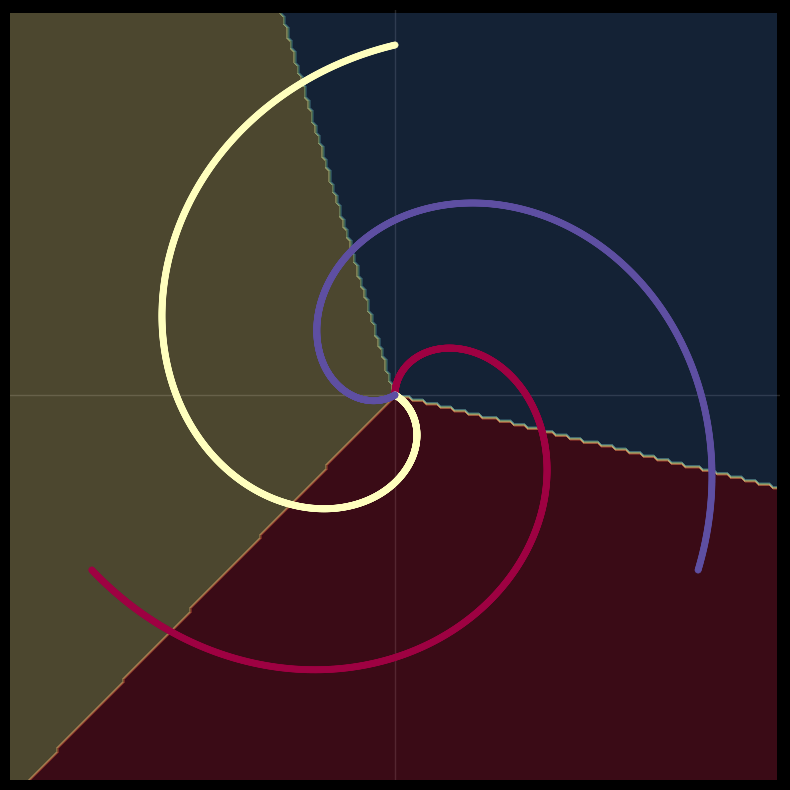

In [100]:
# рисуем обученную модель и визуально показываем,
# как распределились классы
print(model)
plot_model(X, y, model)

Обратите внимание, как красиво и как наглядно работает функция plot_model() -- она выводит как сам датасет, так и соответствующие классам области в обученной модели.

Так как мы используем линейную модель, то и деление области датасета на три части выполняется только с помощью прямых, поэтому конечно и точность получается весьма условной. Хотя конечно для быстрой и грубой оценки даже такая модель будет работать удовлетворительно.

## **Двухслойная нейронная сеть**

Теперь внесём в наш алгоритм две маленькие поправки.

Во-первых, добавим наконец нашей модели скрытый промежуточный слой.

Какую функцию активации использовать? Одно из стандартных решений -- это **ReLU**, довольно странная на первый взгляд функция, которая просто возвращает x, если x больше ноля, или ноль в противном случае. Но как ни удивительно, именно ReLU подходит к многим типовым задачам, причём комбинируя функции ReLU, можно аппроксимировать любую другую функцию, а сама она, очевидно, нетребовательна к ресурсам в плане реализации. Поэтому ReLU рекомендуется к применению в качестве первого шага эксперимента.

Про функции активации и их выбор:

https://neurohive.io/ru/osnovy-data-science/activation-functions/

И вторая поправка -- заменим алгоритм оптимизации SGD на более точный в данном случае Adam.


In [101]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

lambda_l2 = 0.00001
lr = 0.1
n_epochs = 1000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_l2)
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
   loss = train_step(X, y)

print(loss)

0.00782893318682909


Посмотрите, как теперь красиво и точно обучилась наша модель!

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


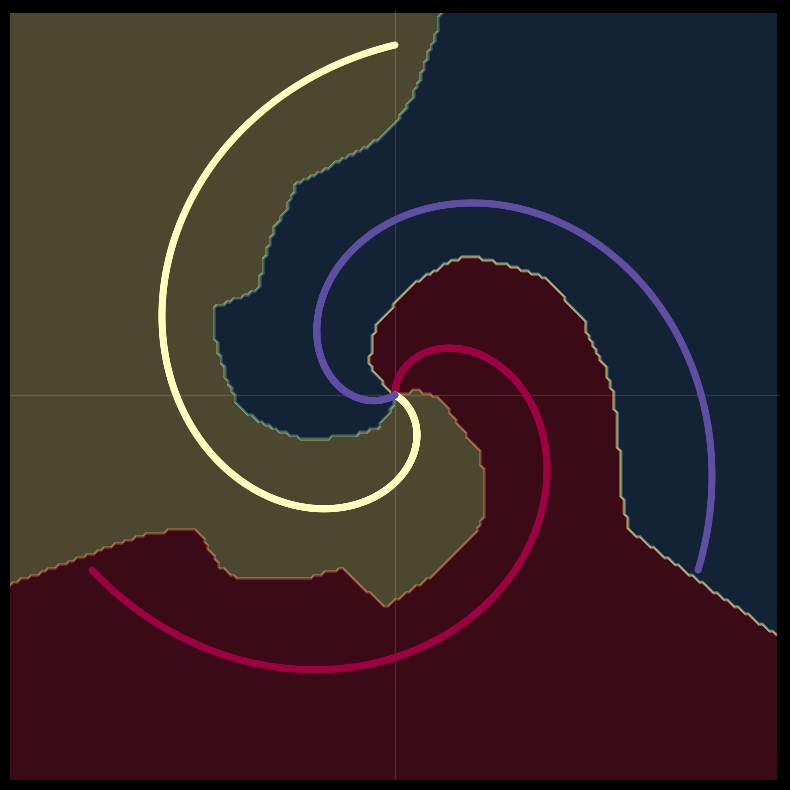

In [102]:
# визуализируем
print(model)
plot_model(X, y, model)

## **Задание**

Найдите самостоятельно подобные достаточно сложные датасеты (или код их генерации) из нескольких (четыре и больше) классов значений, хорошо обучите двухслойную нейронную сеть и визуализируйте результат с помощью plot_lib.



---

В следующем занятии мы переходим к популярной теме классификации изображений -- рукописных цифр.

In [103]:
import torch
import random
from torch import nn, optim
import numpy as np
import math
from IPython import display
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import pandas as pd

def set_default(figsize=(10, 10)):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)

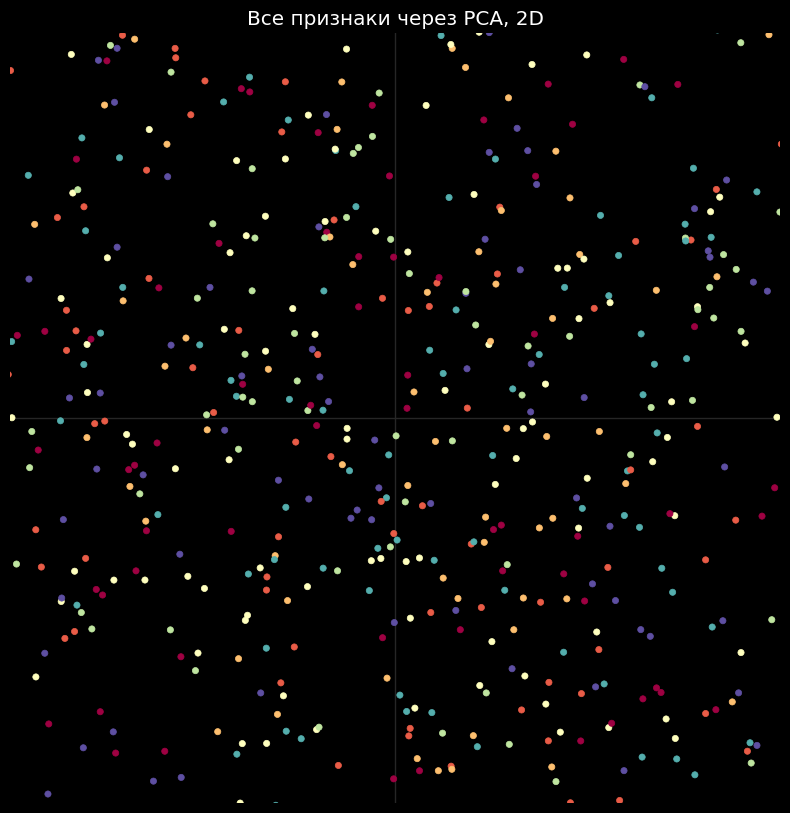

In [104]:
# загружаем данные из сети:
set_default()
data = pd.read_csv("https://raw.githubusercontent.com/Voldek404/High-school-of-programming/refs/heads/main/PyTorch/Datasets/seven_class_dataset.csv")
data.head() # проверяем, правильно ли загрузилось
X = data.iloc[:, :-1].values  # первые 8 признаков
y = data["target"].values
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long) - 1
num_features = X_t.shape[1]

X_np = X_t.numpy()

# 2. PCA на 2 компоненты
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

# 3. Конвертируем обратно в тензор
X_pca_t = torch.tensor(X_pca, dtype=torch.float32)

# 4. Рисуем один график для всех признаков
plot_data(X_pca_t, y_t)
plt.title("Все признаки через PCA, 2D")
plt.show()

In [105]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # количество точек на признак
D = 8  # размерность данных (плоскость)
C = 7  # количество признаков
H = 100  # количество нейронов в скрытом слое

# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [106]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(X_t, y_t):
        model.train()
        X_t = X_t.to(device)
        y_t = y_t.to(device)
        yhat = model(X_t)
        loss = loss_fn(yhat, y_t)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [112]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

lambda_l2 = 0.00001
lr = 0.1
n_epochs = 1500
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_l2)
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    loss = train_step(X_t, y_t)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}: loss={loss:.4f}")

print(loss)

Epoch 100: loss=0.8666
Epoch 200: loss=0.5084
Epoch 300: loss=0.3517
Epoch 400: loss=0.3255
Epoch 500: loss=0.1827
Epoch 600: loss=0.1445
Epoch 700: loss=0.1176
Epoch 800: loss=0.0970
Epoch 900: loss=0.1316
Epoch 1000: loss=0.0895
Epoch 1100: loss=0.0749
Epoch 1200: loss=0.0658
Epoch 1300: loss=0.0594
Epoch 1400: loss=0.0546
Epoch 1500: loss=0.0504
0.050353821367025375


In [121]:
print(model)
plot_model(X_t, y_t, model)


Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=7, bias=True)
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (48400x2 and 8x100)